In [13]:
import numpy as np
import matplotlib.pyplot as plt
import lime
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Folder with NIRSPEC spectra
data_folder = Path(f'./data')

# CEERs 1027 redshift
z_obj = 7.8334

# Multiple spectra from the same galaxy observed with diference dispensers
spec_list = data_folder.glob('*.fits')
spec_list = list(spec_list)

In [29]:
s = spec_list[1]

LiMe INFO: Normalizing input flux by 1.573140441358099e-09


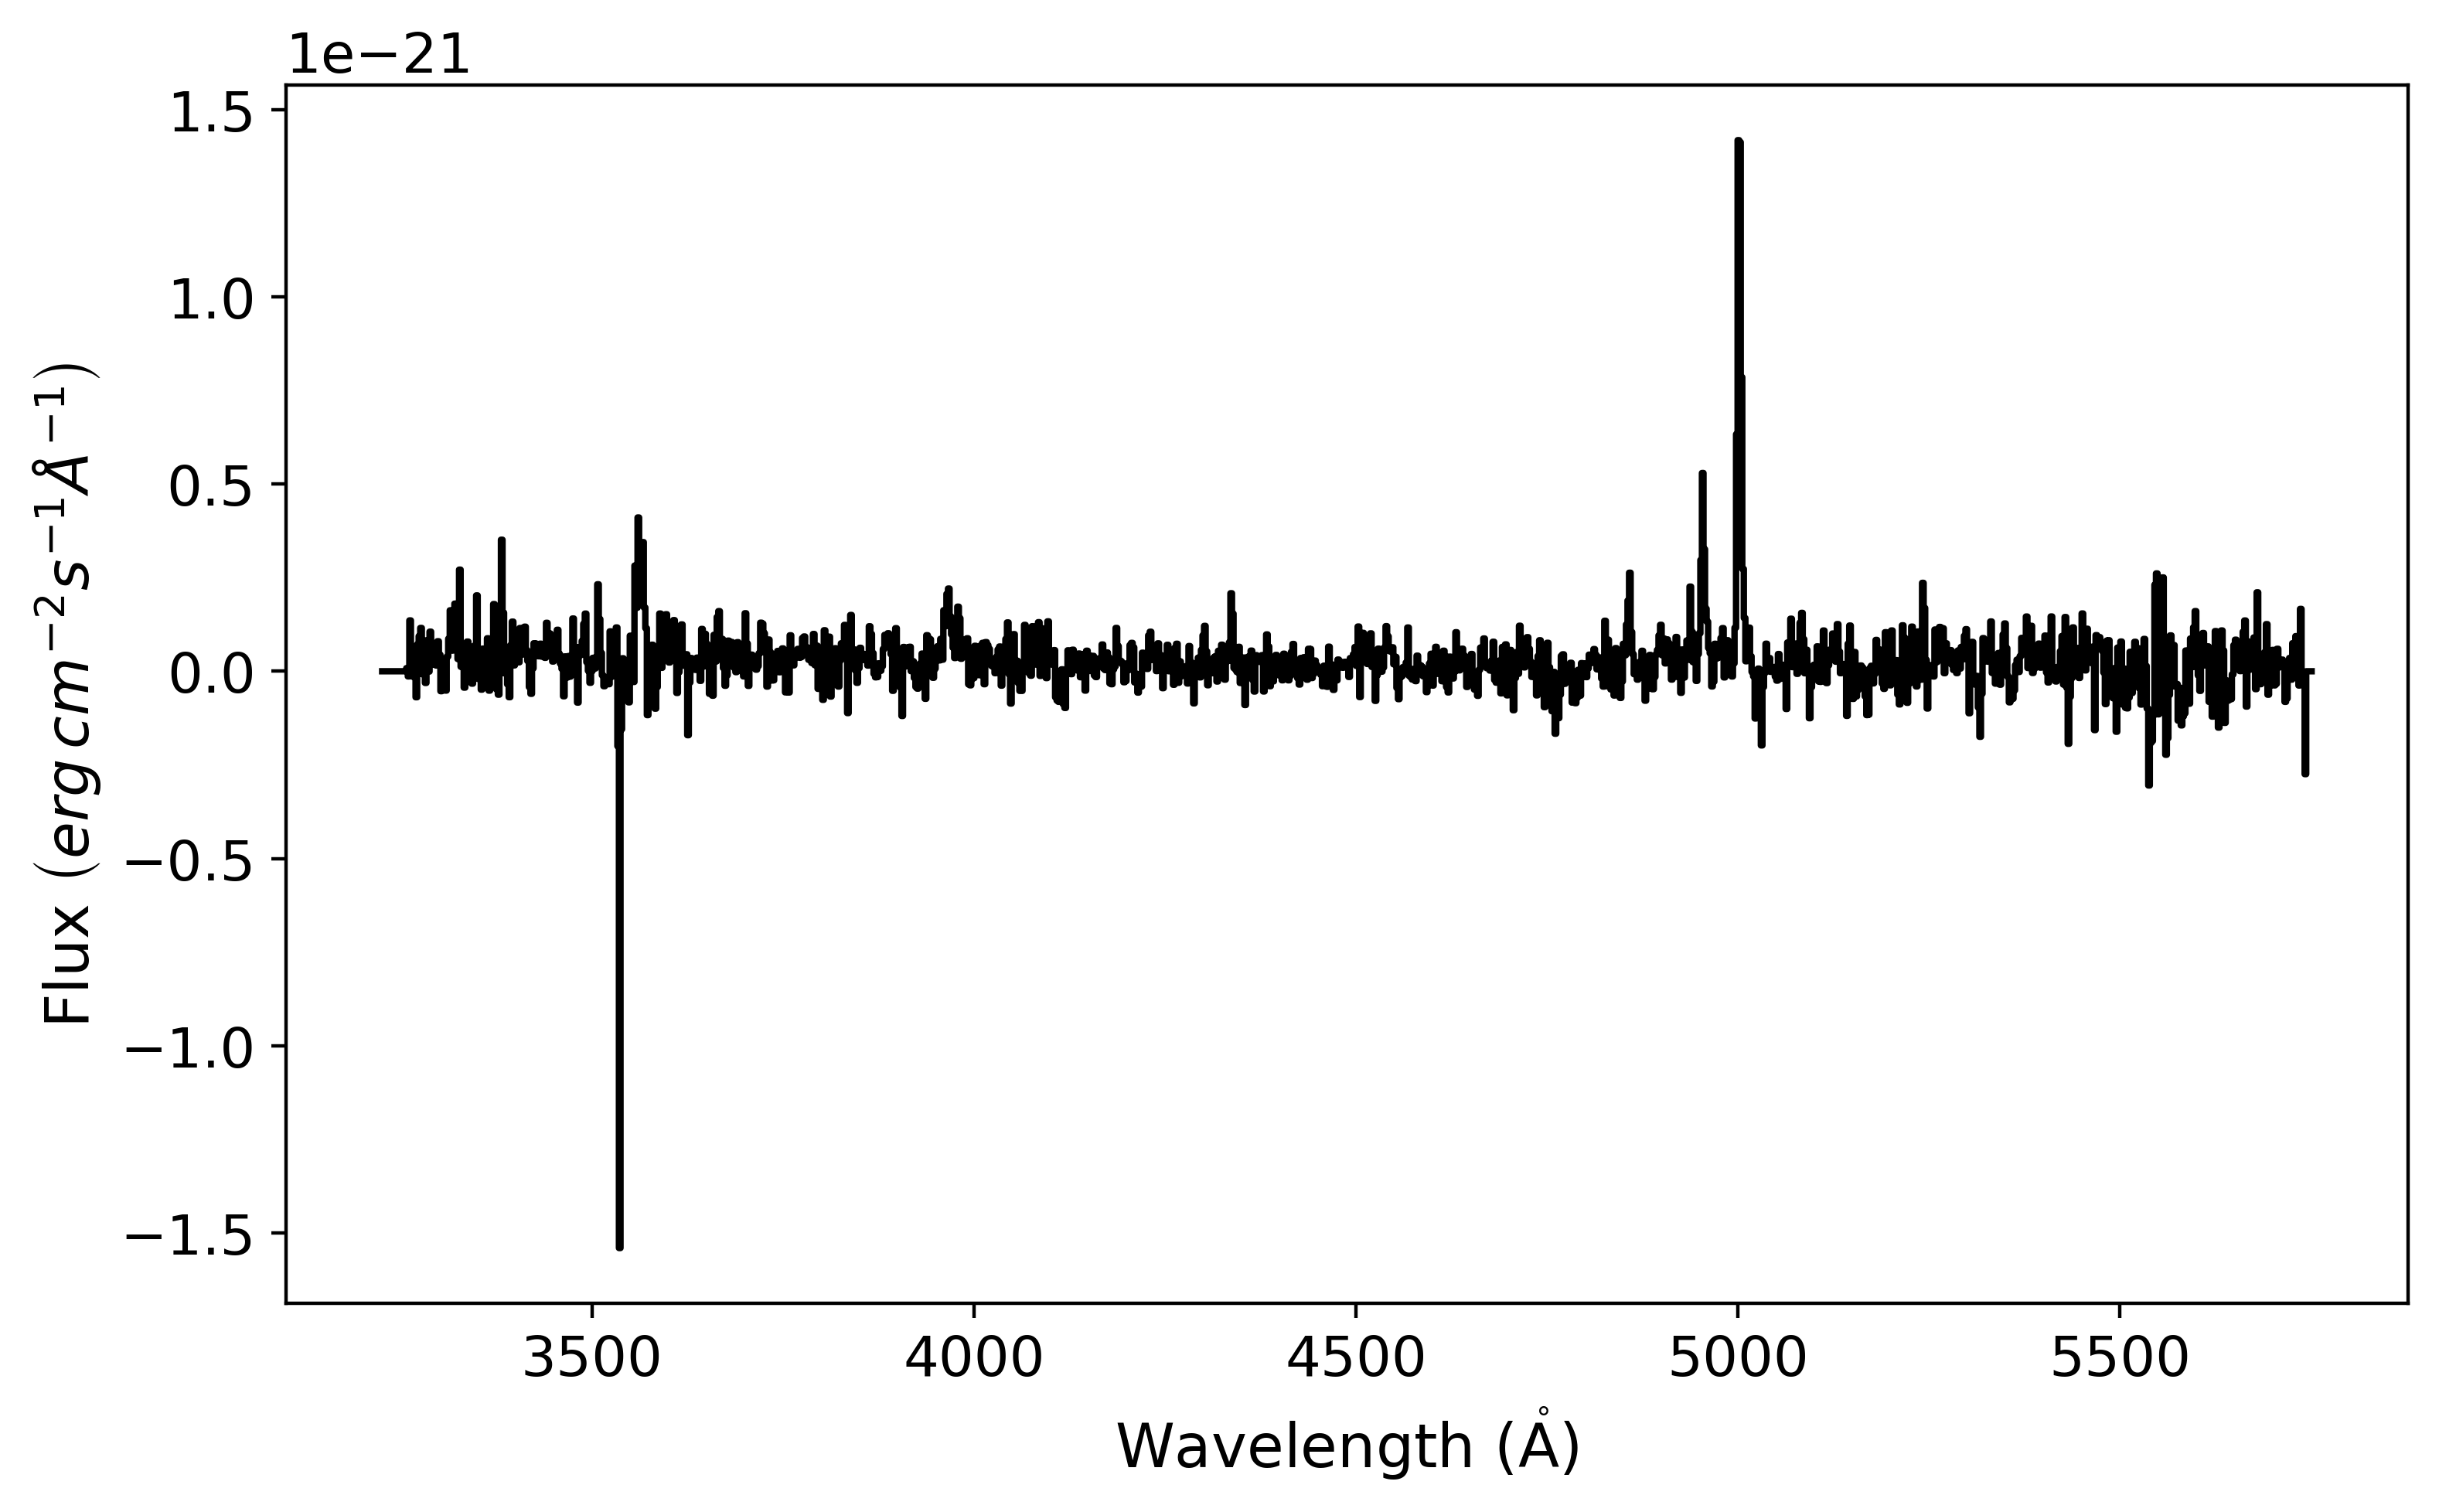

In [36]:
spec = lime.Spectrum.from_file(s, 'nirspec', redshift=z_obj)

# Convert units as necessary
spec.unit_conversion(wave_units_out='Angstrom', flux_units_out='FLAM')

# Visualize the spectrum
spec.plot.spectrum(rest_frame=True)

In [31]:
# Compute the FWHM curve for the instrument observation (removing data mask)
wave_obs = spec.wave.data
deltalamb_arr = np.diff(wave_obs)
R_arr = wave_obs[1:] / deltalamb_arr
FWHM_arr = wave_obs[1:] / R_arr

In [109]:
l = spec.wave.data
f = spec.flux.data

In [110]:
full_df = lime.line_bands(vacuum=True)

# Cropping to the "main lines"
candidate_lines = ["H1_1216A", "He2_1640A", "Ne5_3427A", "O2_3727A", "H1_4342A",
                   "H1_4863A", "O3_4960A", "O3_5008A", "H1_6565A", "S2_6718A",
                   "He1_10833A"]
# candidate_lines = ["O2_3727A", "H1_4863A", "O3_4960A", "O3_5008A", "H1_6565A"]
# lines_df = full_df.loc[candidate_lines]
lines_df = full_df
# The theoretical wavelengths (vacuum) are in the first column:
wave_theo = lines_df.wavelength.to_numpy()

In [118]:
z = spec.redshift

In [122]:
def log_likelihood(theta, x, y, lines):
    z = theta
    sum = 0
    for line in lines:
        w = line * (1 + z)
        idx = wavelength_to_index(x, w)
        if idx is None:
            continue
        sum += y[idx]
    return sum

def log_prior(theta):
    z = theta
    if z < 0 or z > 10:
        return -np.inf
    return 0

def log_posterior(theta, x, y, lines):
    return log_likelihood(theta, x, y, lines) + log_prior(theta)


In [154]:
log_posterior(z_obj + 0.3, spec.wave.data, spec.flux.data, wave_theo)

6.614492777556665e-23

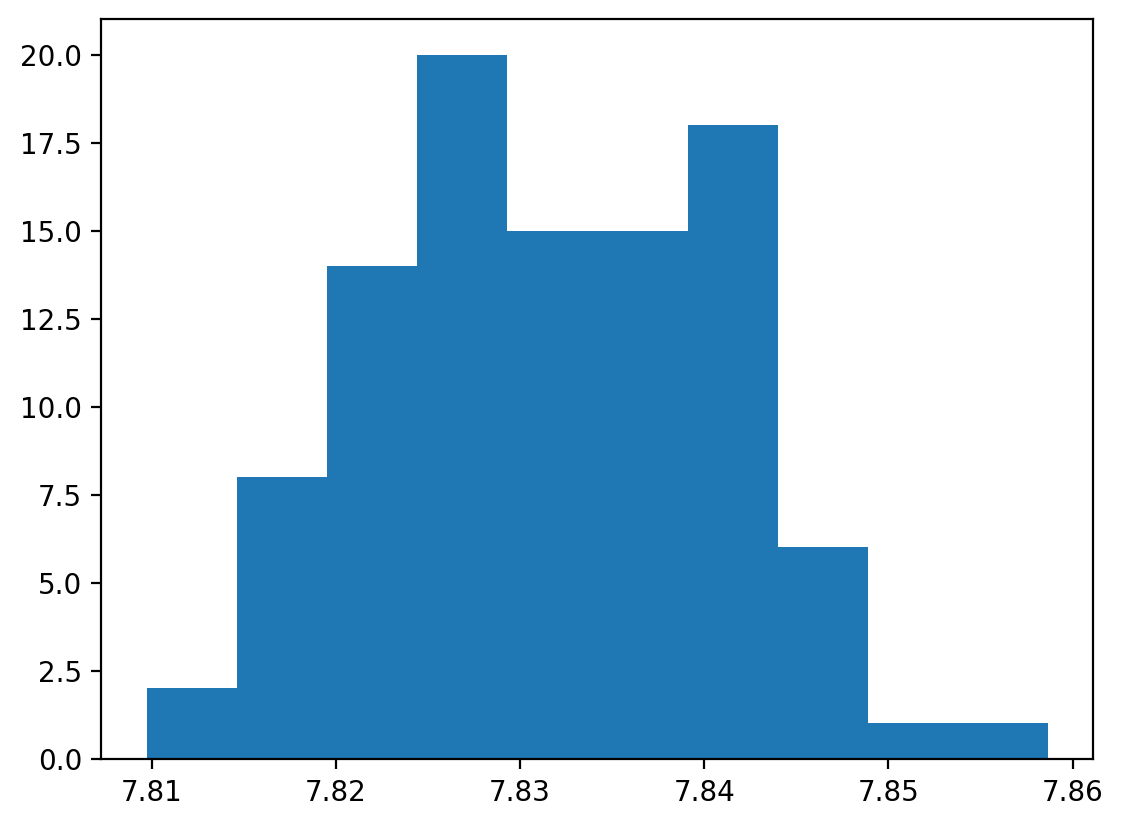

In [155]:
_ = plt.hist(pos.flatten())

In [153]:
import emcee

nwalkers, ndim = 100, 1
pos = z_obj + 1e-2 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_posterior, 
                                args=(spec.wave.data, spec.flux.data, wave_theo))
sampler.run_mcmc(pos, 500, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[1.17675107]
 [2.63506919]
 [5.28669505]
 [9.55988611]
 [1.34889303]
 [6.33520946]
 [5.26233118]
 [1.55493607]
 [3.10427672]
 [7.94984999]
 [3.88771443]
 [4.56467063]
 [8.20088934]
 [7.28702843]
 [3.09859878]
 [7.7182582 ]
 [3.39271902]
 [3.28680272]
 [0.64736429]
 [1.42074089]
 [4.79156215]
 [6.78193886]
 [6.90600079]
 [1.4191352 ]
 [0.68627229]
 [0.01215069]
 [4.12033304]
 [5.2278052 ]
 [1.30105859]
 [5.84334774]
 [8.95010126]
 [9.53302113]
 [4.26741585]
 [6.657888  ]
 [2.75177881]
 [1.53301119]
 [5.39382997]
 [1.16313425]
 [6.84395789]
 [1.56565944]
 [5.27460481]
 [5.39169468]
 [1.90973778]
 [7.39923615]
 [9.74810042]
 [4.59776707]
 [4.56186302]
 [6.60000544]
 [2.82445203]
 [1.29367865]
 [5.17237368]
 [5.41656478]
 [5.64902235]
 [9.95908041]
 [3.06125206]
 [9.51853061]
 [7.36556164]
 [9.56304764]
 [1.28671521]
 [7.93641017]
 [7.43669061]
 [3.81698561]
 [5.45423747]
 [2.1187802 ]
 [3.48960364]
 [0.74723883]
 [9.52189661]
 [8.94732932]
 [8.09918971]
 [9.9209178 ]
 [4.76176294]


In [156]:
samples = sampler.get_chain(discard=100, thin=15, flat=True)

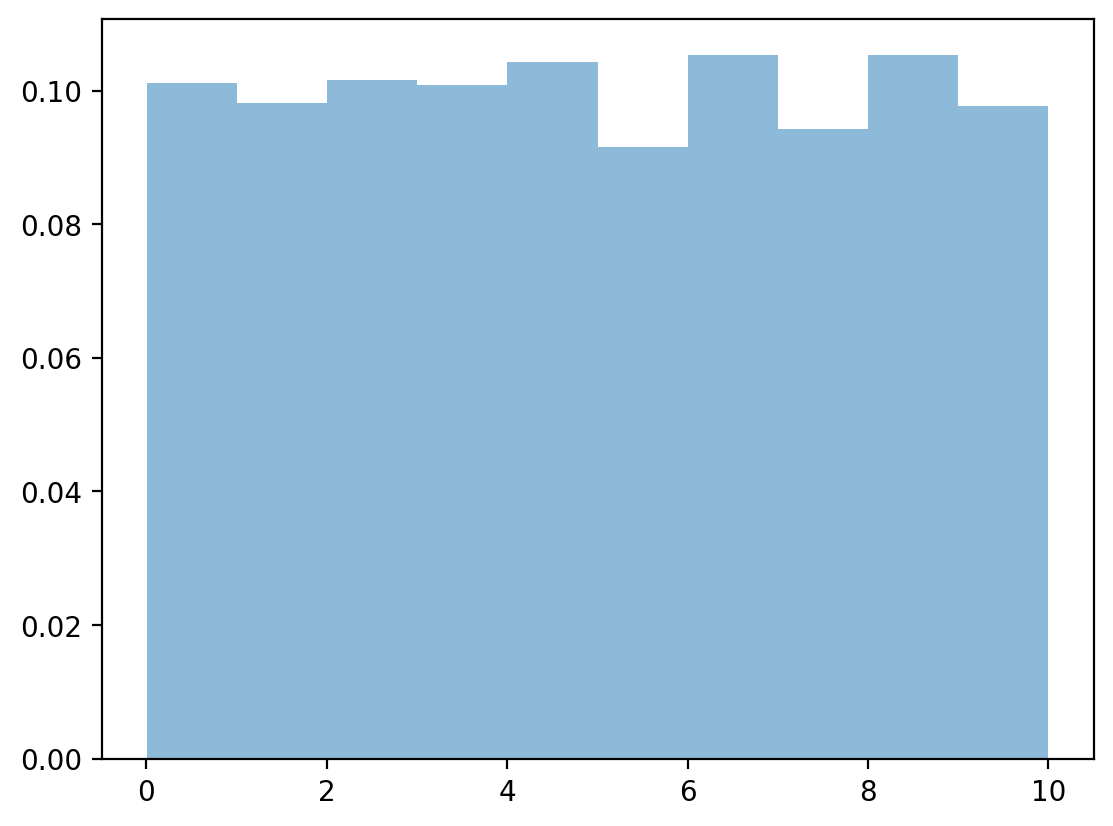

In [157]:
_ = plt.hist(samples, density=True, alpha=0.5)

In [163]:
def wavelength_to_index(wave, wave_theo):
    if wave_theo < wave[0] or wave_theo > wave[-1]:
        return None
    return np.argmin(np.abs(wave - wave_theo))

def calculate_sum(wave, flux, wave_theo):
    sum = 0
    for wave_t in wave_theo:
        idx = wavelength_to_index(wave, wave_t)
        if idx is None:
            continue
        sum += flux[idx]
    return sum

In [164]:
sums = []
zs = np.linspace(z_obj - 5, z_obj + 5, 10000)
for z in zs:
    sums.append(calculate_sum(spec.wave.data, spec.flux.data, wave_theo * (1 + z)))

Text(0, 0.5, 'Metric')

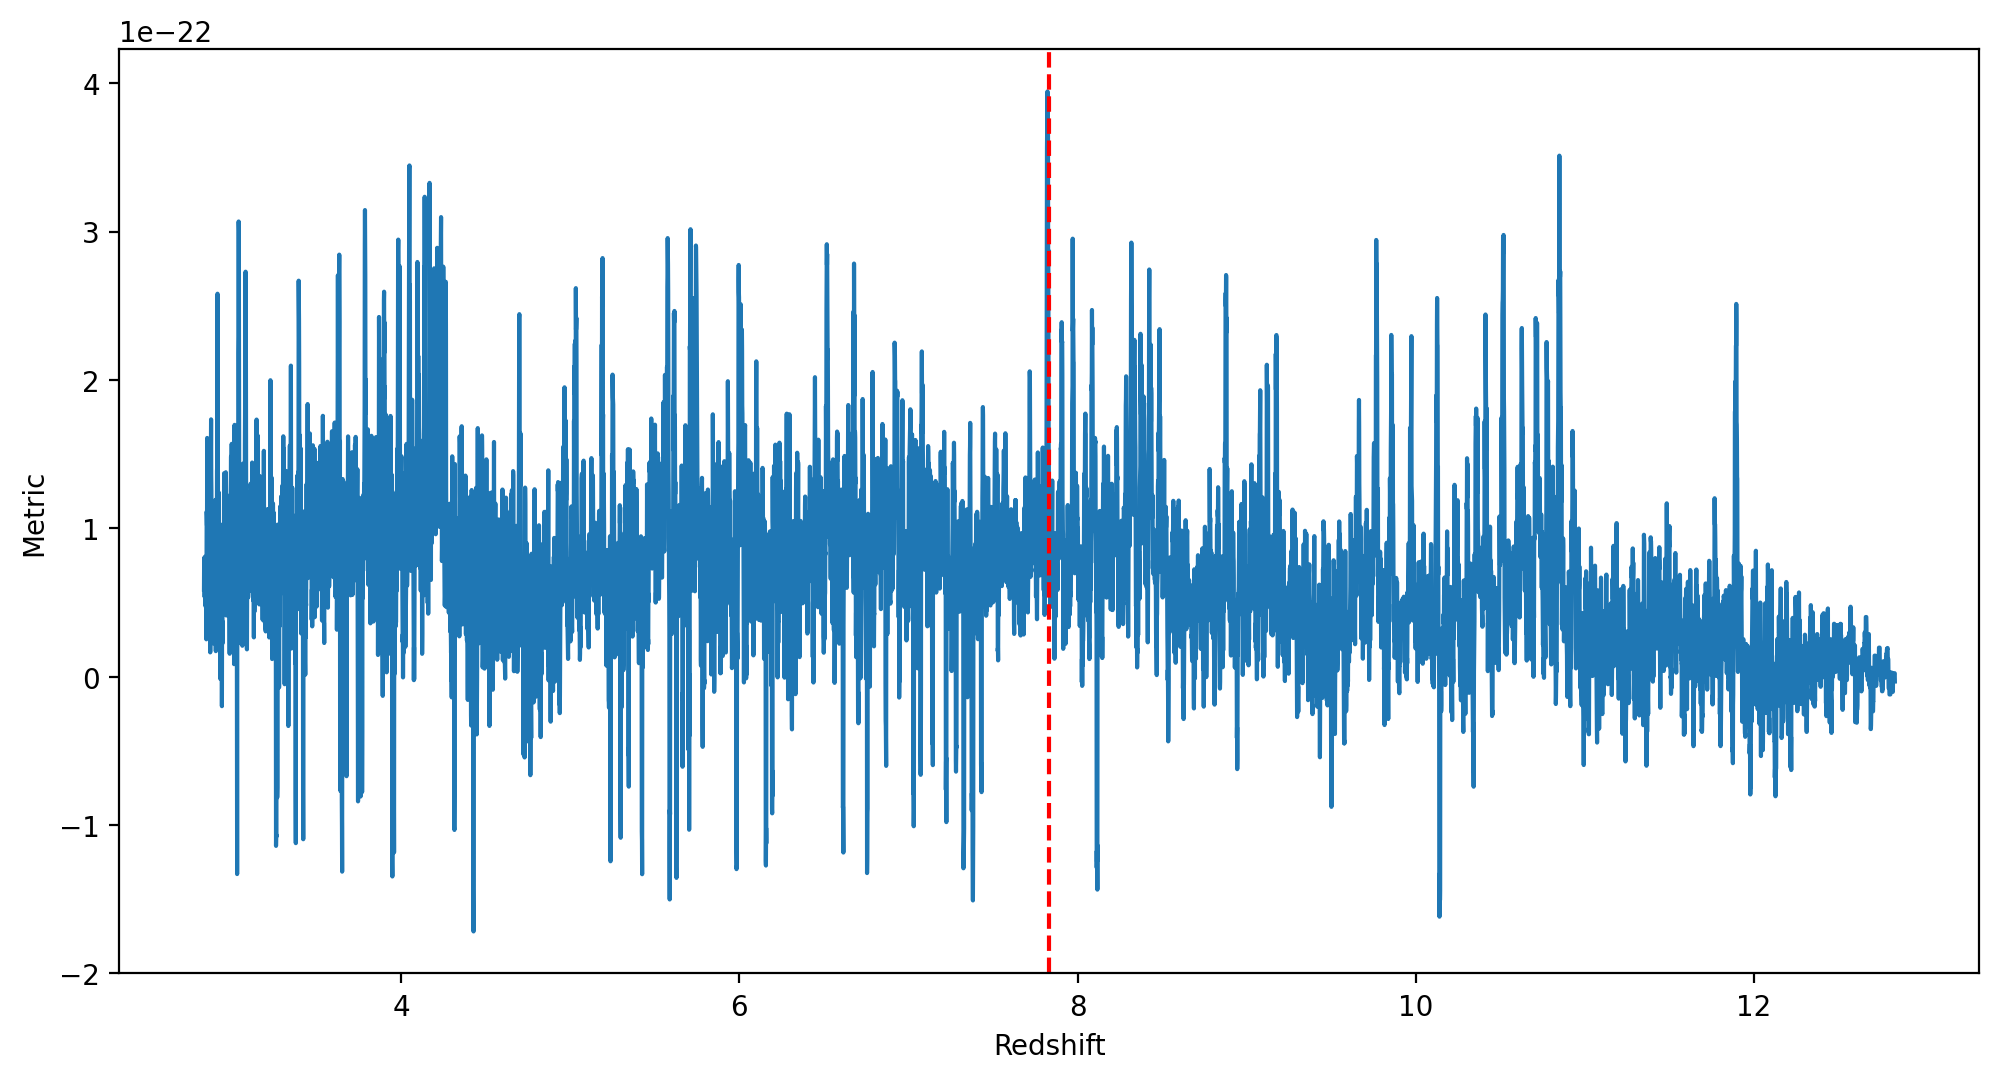

In [165]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zs, sums)
ax.axvline(z_obj, color='r', linestyle='--')

ax.set_xlabel('Redshift')
ax.set_ylabel('Metric')

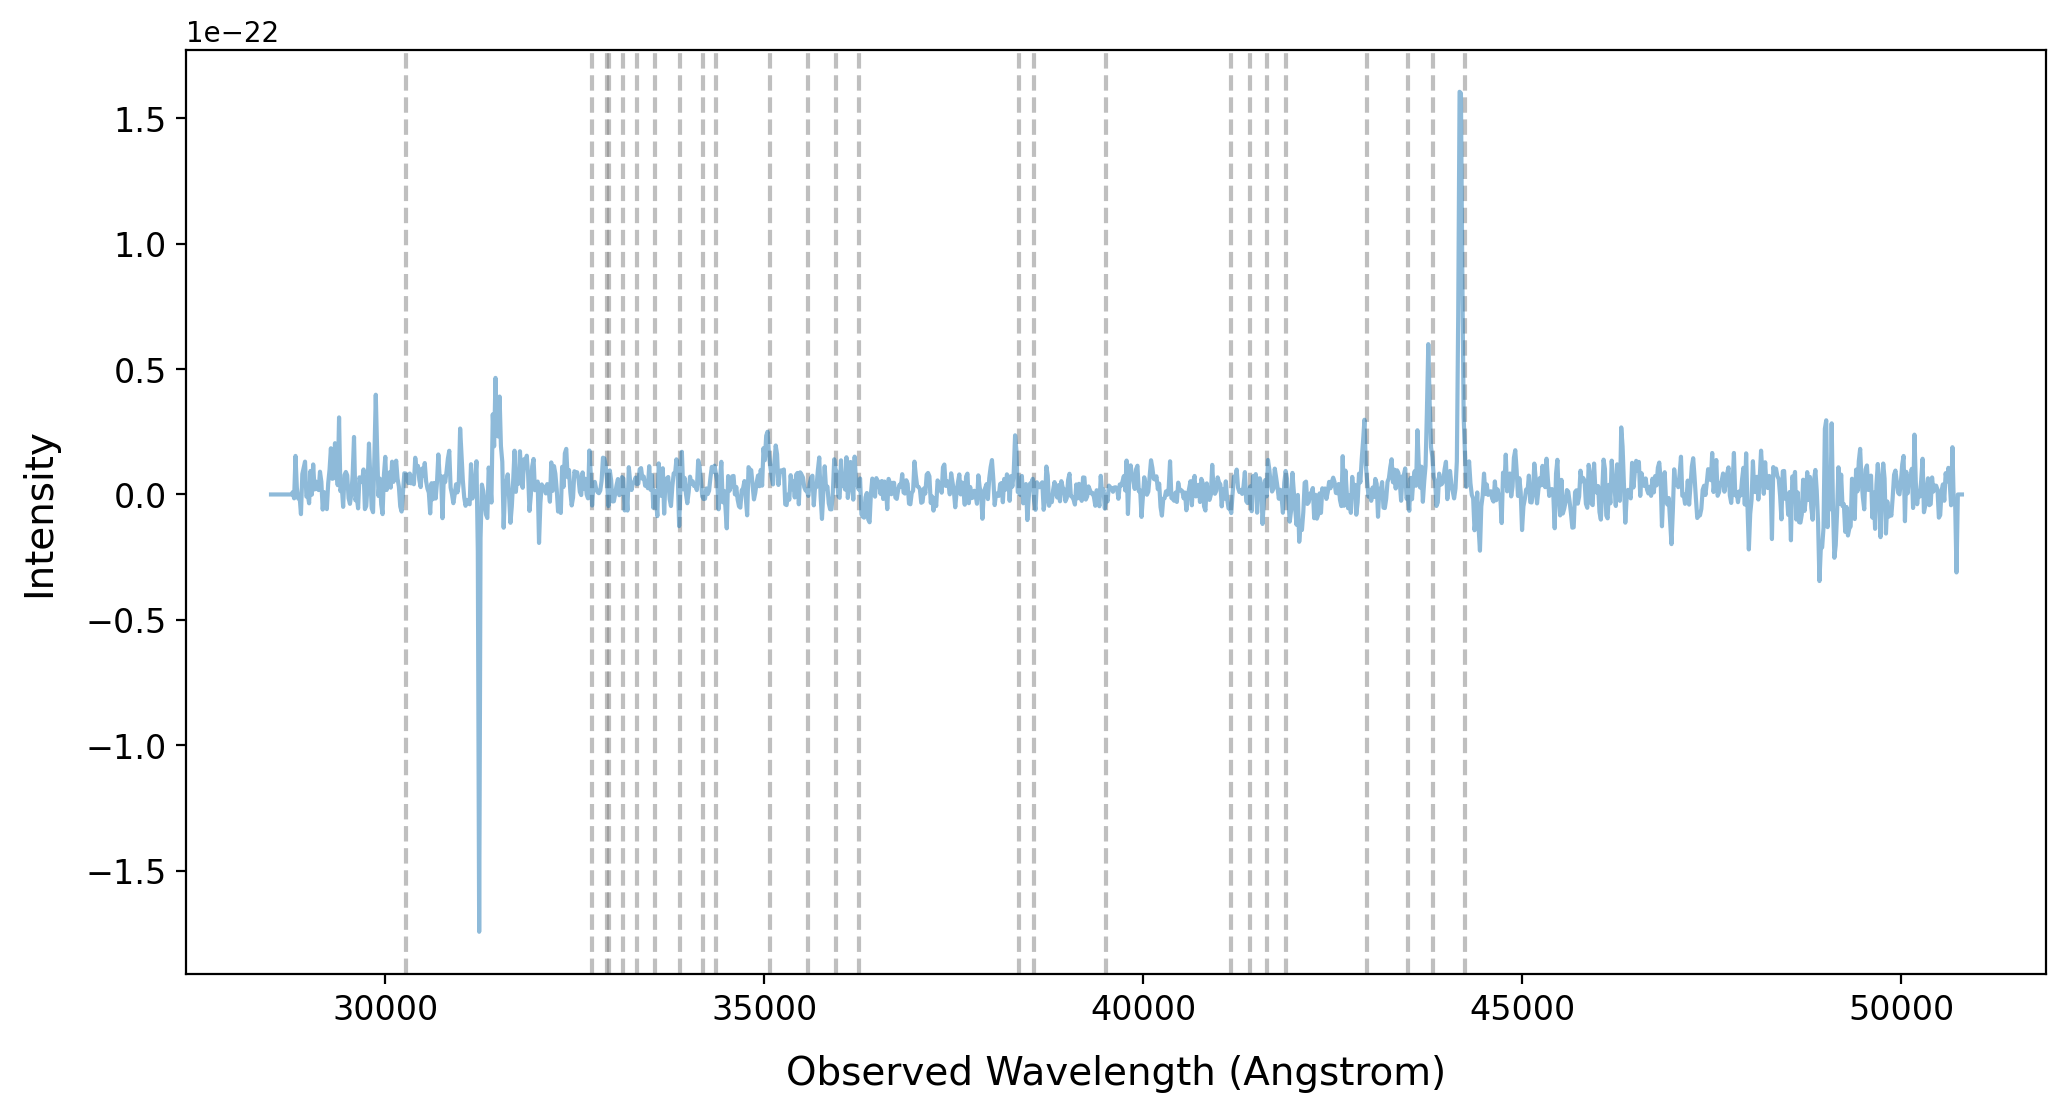

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(l, f, alpha=0.5)

running_sum = 0
for w in wave_theo:
    corrected_w = w * (1 + spec.redshift + 0.0)
    w_idx = wavelength_to_index(spec.wave.data, corrected_w)
    if w_idx is None:
        continue
    running_sum += f[w_idx]

    ax.axvline(corrected_w, color='grey', linestyle='--', zorder=0, alpha=0.5)

ax.set_ylabel("Intensity", fontsize=14, labelpad=10)
ax.set_xlabel("Observed Wavelength (Angstrom)", fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

In [91]:
running_sum

-1.2650610815309053e-24